<a href="https://colab.research.google.com/github/Shadowhunterandbee/Text-to-Image/blob/main/Failed-Approach%20%3AGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
# Project name used for jovian.commit
project_name = '03-cifar10-feedforward'

In [ ]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:10<00:00, 16054816.69it/s]


Extracting data/cifar-10-python.tar.gz to data/


Label (numeric): 6


NameError: name 'classes' is not defined

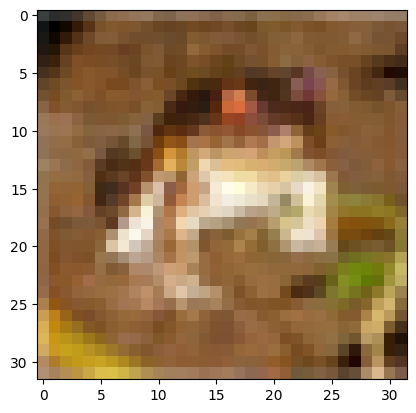

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [ ]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
batch_size=120


In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.is_available()

In [ ]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl

        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Count the number of images in the training and test datasets
dataset_size = len(trainset)
test_dataset_size = len(testset)

print(f"Number of images in the training dataset: {dataset_size}")
print(f"Number of images in the test dataset: {test_dataset_size}")


In [ ]:
input_size = 3*32*32
output_size = 10

In [ ]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        return out

In [ ]:
model = to_device(CIFAR10Model(), device)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
data_dir = '/content/data/cifar-10-batches-py'
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Display some sample images
def show_samples(dataset, num_samples=15):
    for i in range(num_samples):
        plt.subplot(4, 10, i + 1)
        plt.axis('off')
        plt.imshow(np.transpose(dataset[i][0].numpy(), (1, 2, 0)) * 0.5 + 0.5)
    plt.show()

show_samples(trainset)


In [ ]:
# Define the Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512*2*2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define the Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 512*2*2),
            nn.ReLU(True),
            nn.BatchNorm1d(512*2*2),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Initialize models
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training function
def train_gan(num_epochs=50, batch_size=128):
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            # Train Discriminator
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            labels_real = torch.ones(batch_size, 1).to(device)
            labels_fake = torch.zeros(batch_size, 1).to(device)

            # Forward pass real batch
            outputs = discriminator(real_images)
            loss_real = criterion(outputs, labels_real)

            # Forward pass fake batch
            noise = torch.randn(batch_size, 100, device=device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            loss_fake = criterion(outputs, labels_fake)

            # Backprop and optimize for Discriminator
            loss_d = loss_real + loss_fake
            optimizer_d.zero_grad()
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            outputs = discriminator(fake_images)
            loss_g = criterion(outputs, labels_real)

            # Backprop and optimize for Generator
            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()

            if (i+1) % 200 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], D Loss: {loss_d.item()}, G Loss: {loss_g.item()}")

        # Save generated images for visualization
        if (epoch+1) % 10 == 0:
            save_generated_images(epoch+1, generator)

# Save generated images for visualization
def save_generated_images(epoch, generator, num_samples=16, figsize=(4, 4)):
    noise = torch.randn(num_samples, 100, device=device)
    generated_images = generator(noise).cpu().detach()
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=figsize)
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.transpose(generated_images[i].numpy(), (1, 2, 0)))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()

# Train the GAN
train_gan(num_epochs=100)


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    preprocess = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize the image to match the input size of the generator
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])
    img = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img

# Usage
image_url = "https://t4.ftcdn.net/jpg/01/77/47/67/240_F_177476718_VWfYMWCzK32bfPI308wZljGHvAUYSJcn.jpg"
input_image = load_image_from_url(image_url)

# Check if the image is loaded
print(input_image.shape)  # Should print the shape of the loaded image tensor


In [ ]:
import matplotlib.pyplot as plt

# Convert tensor to NumPy array and transpose dimensions
image_np = input_image.squeeze().numpy()  # Remove batch dimension and convert to NumPy array
image_np = image_np.transpose(1, 2, 0)  # Transpose dimensions from (C, H, W) to (H, W, C)

# Rescale the image from [-1, 1] to [0, 1] for visualization
image_np = (image_np + 1) / 2.0

# Display the image
plt.imshow(image_np)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
print(generator)


In [ ]:


!pip install torchsummary
from torchsummary import summary

# Assuming generator is your model object
summary(generator, input_size=(noise_dim,))


In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 2048),
            nn.ReLU(True),
            nn.BatchNorm1d(2048),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming the generator model is already defined and loaded
# generator = Generator().to(device)

# Function to load and preprocess an image from file
def load_image_from_file(filename):
    img = Image.open(filename)
    preprocess = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize the image to match the input size of the generator
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])
    img = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img

# Load your image from file
image_filename = "/content/IMG_3656.JPG"  # Provide the path to your image file
input_image = load_image_from_file(image_filename)

# Move input image to the same device as the generator model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_image = input_image.to(device)

# Switch model to evaluation mode to use running estimates for BatchNorm
generator.eval()

# Generate random noise with the shape expected by the generator
batch_size = input_image.size(0)
noise_dim = 100
noise = torch.randn(batch_size, noise_dim, device=device)

# Generate an image using the noise
with torch.no_grad():
    generated_image = generator(noise)

# Convert generated image tensor to NumPy array and transpose dimensions
generated_image_np = generated_image.squeeze().cpu().numpy()  # Remove batch dimension and convert to NumPy array
generated_image_np = generated_image_np.transpose(1, 2, 0)  # Transpose dimensions from (C, H, W) to (H, W, C)

# Rescale the generated image from [-1, 1] to [0, 1] for visualization
generated_image_np = (generated_image_np + 1) / 2.0

# Display the generated image
plt.imshow(generated_image_np)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
!pip install realesrgan


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from realesrgan import RealESRGAN

# Function to load and preprocess an image from file
def load_image_from_file(filename):
    img = Image.open(filename)
    preprocess = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize the image to match the input size of the generator
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])
    img = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img

# Load your image from file
image_filename = "/content/IMG_3656.JPG"  # Provide the path to your image file
input_image = load_image_from_file(image_filename)

# Move input image to the same device as the generator model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_image = input_image.to(device)

# Assuming the generator model is already defined and loaded
# generator = Generator().to(device)
# Switch model to evaluation mode to use running estimates for BatchNorm
generator.eval()

# Generate random noise with the shape expected by the generator
batch_size = input_image.size(0)
noise_dim = 100
noise = torch.randn(batch_size, noise_dim, device=device)

# Generate an image using the noise
with torch.no_grad():
    generated_image = generator(noise)

# Convert generated image tensor to NumPy array and transpose dimensions
generated_image_np = generated_image.squeeze().cpu().numpy()  # Remove batch dimension and convert to NumPy array
generated_image_np = generated_image_np.transpose(1, 2, 0)  # Transpose dimensions from (C, H, W) to (H, W, C)

# Rescale the generated image from [-1, 1] to [0, 1] for visualization
generated_image_np = (generated_image_np + 1) / 2.0
generated_image_pil = Image.fromarray((generated_image_np * 255).astype('uint8'))

# Apply super-resolution using Real-ESRGAN
sr_model = RealESRGAN(device, scale=4)
# Load pre-trained weights; ensure you have the weights file 'RealESRGAN_x4.pth' in the working directory
sr_model.load_weights('RealESRGAN_x4.pth')

# Super-resolve the image
sr_image = sr_model.predict(generated_image_pil)

# Display the super-resolved image
plt.imshow(sr_image)
plt.axis('off')  # Hide axes
plt.show()
